In [49]:
%reset -f

pip install pandas beancount matplotlib seaborn


In [50]:
from beancount.loader import load_file
import pandas as pd

def load_beancount_transactions(file_path):
    """
    Load transactions from a Beancount ledger file into a pandas DataFrame.

    Parameters:
    - file_path (str): Path to the Beancount file.

    Returns:
    - pd.DataFrame: DataFrame containing transaction details.
    """
    entries, _, _ = load_file(file_path)

    txns = []
    for entry in entries:
        if entry.__class__.__name__ == "Transaction":
            txn_id = id(entry)  # new unique ID for this transaction
            for posting in entry.postings:
                txns.append({
                    "transaction_id": txn_id,
                    "date": entry.date,
                    "narration": entry.narration,
                    "meta": entry.meta,
                    "account": posting.account,
                    "units": posting.units.number,
                    "item": posting.units.currency
                })
    df = pd.DataFrame(txns)
    # Convert date to datetime
    df["date"] = pd.to_datetime(df["date"])  
    # Convert transaction size to numeric
    df['units'] = pd.to_numeric(df['units'], errors='raise')
    # Get type of the posting from meta
    df['type'] = df['meta'].apply(lambda m: m.get('type') if isinstance(m, dict) else None)
    df = df.drop(columns=['meta'])
    
    return df


In [51]:
df = load_beancount_transactions("./tab-data/bartab.beancount")
df

,transaction_id,date,narration,account,units,item,type
0,137705626385008,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Liabilities:Bar:Members:Bloemist,5.3,EUR,None
1,137705626385008,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Assets:InitialBalances,-5.3,EUR,None
2,137705626384448,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Liabilities:Bar:Members:Koen,-0.5,EUR,None
3,137705626384448,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Assets:InitialBalances,0.5,EUR,None
4,137705626382656,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Liabilities:Bar:Members:Bart,-11.8,EUR,None
...,...,...,...,...,...,...,...
100288,137705470232720,2025-05-29,Gust gave DJefke a gift of €41.70,Liabilities:Bar:Members:DJefke,-41.7,EUR,transfer
100289,137705470233504,2025-05-29,Mateo bought 1 items for €1.50,Assets:Inventory:Bar,-1.0,SODA,purchase
100290,137705470233504,2025-05-29,Mateo bought 1 items for €1.50,Liabilities:Bar:Members:Mateo,1.0,SODA,purchase
100291,137705470233504,2025-05-29,Mateo bought 1 items for €1.50,Liabilities:Bar:Members:Mateo,1.5,EUR,purchase


## Load products

In [52]:
import yaml
import pandas as pd

def load_product_data(yaml_path):
    """
    Load product data from a YAML file and expand the 'payback' dictionary into separate columns.

    Parameters:
    - yaml_path (str): Path to the YAML file containing product information.

    Returns:
    - pd.DataFrame: DataFrame with product details and expanded 'payback' fields.
    """
    with open(yaml_path, "r") as f:
        price_data = yaml.safe_load(f)
    
    df_products = pd.DataFrame(price_data)

    # Expand the 'payback' dictionary into its own columns
    if 'payback' in df_products.columns:
        payback_df = df_products['payback'].apply(
            lambda x: x if isinstance(x, dict) else {}
        ).apply(pd.Series)
        payback_df.columns = [f'payback_{col}' for col in payback_df.columns]
        df_products = pd.concat([df_products.drop(columns=['payback']), payback_df], axis=1)
    
    # Rename 'currency' to 'item'
    df_products.rename(columns={'currency': 'item'}, inplace=True)
    return df_products

df_products = load_product_data("./tab-data/static/products.yml")
df_products


,name,price,event_price,item,category,visible,payback_account,payback_amount
0,Soda,1.5,2.50,SODA,drink,True,NaN,NaN
1,Cecemel,0.7,1.00,CHOCO_MILK,drink,False,NaN,NaN
2,Fritz / Club Mate Cola,2.5,3.50,GERMAN,drink,True,NaN,NaN
3,Club Mate,3.0,4.00,CM,drink,True,NaN,NaN
4,Tea,0.5,0.75,TEA,drink,False,NaN,NaN
...,...,...,...,...,...,...,...,...
63,Pizza,2.5,4.00,PIZZA,food,False,Liabilities:Bar:Members:Yvan,1.5
64,SPRITE,2.0,3.00,SPRITE,DRINK,False,NaN,NaN
65,Cha-Cha,0.5,0.75,CHACHA,food,False,NaN,NaN
66,Leffe,2.0,3.00,LEFFE,alcohol,False,NaN,NaN


# Most sold items for each year

In [53]:
df_merged = df.merge(df_products, how="left", on="item")
df_merged

,transaction_id,date,narration,account,units,item,type,name,price,event_price,category,visible,payback_account,payback_amount
0,137705626385008,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Liabilities:Bar:Members:Bloemist,5.3,EUR,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,137705626385008,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Assets:InitialBalances,-5.3,EUR,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,137705626384448,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Liabilities:Bar:Members:Koen,-0.5,EUR,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,137705626384448,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Assets:InitialBalances,0.5,EUR,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,137705626382656,1970-01-01,Initial balance transfer for Liabilities:Bar:M...,Liabilities:Bar:Members:Bart,-11.8,EUR,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100288,137705470232720,2025-05-29,Gust gave DJefke a gift of €41.70,Liabilities:Bar:Members:DJefke,-41.7,EUR,transfer,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100289,137705470233504,2025-05-29,Mateo bought 1 items for €1.50,Assets:Inventory:Bar,-1.0,SODA,purchase,Soda,1.5,2.5,drink,True,NaN,NaN
100290,137705470233504,2025-05-29,Mateo bought 1 items for €1.50,Liabilities:Bar:Members:Mateo,1.0,SODA,purchase,Soda,1.5,2.5,drink,True,NaN,NaN
100291,137705470233504,2025-05-29,Mateo bought 1 items for €1.50,Liabilities:Bar:Members:Mateo,1.5,EUR,purchase,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Filter for purchases from bar cash
df_sales = df_merged[
    (df_merged['type'] == 'purchase') &
    (df_merged['account'] == 'Assets:Inventory:Bar') &
    (df_merged['item'] != 'EUR')
].copy()

# Extract year and ensure units are numeric
df_sales['year'] = df_sales['date'].dt.year
df_sales['units'] = - df_sales['units']
df_sales

,transaction_id,date,narration,account,units,item,type,name,price,event_price,category,visible,payback_account,payback_amount,year
29159,137705560371520,2018-11-25,TQ bought 3 items for €6.50,Assets:Inventory:Bar,2.0,CMRED,purchase,Club Mate Red,2.0,3.0,drink,False,NaN,NaN,2018
29161,137705560371520,2018-11-25,TQ bought 3 items for €6.50,Assets:Inventory:Bar,1.0,DUVEL,purchase,Fancy Beer,2.5,4.0,alcohol,True,NaN,NaN,2018
29165,137705560372304,2018-11-25,TQ bought 1 items for €2.00,Assets:Inventory:Bar,1.0,CMRED,purchase,Club Mate Red,2.0,3.0,drink,False,NaN,NaN,2018
29169,137705560373088,2018-11-25,TQ bought 1 items for €2.00,Assets:Inventory:Bar,1.0,CMRED,purchase,Club Mate Red,2.0,3.0,drink,False,NaN,NaN,2018
29173,137705560374096,2018-11-25,TQ bought 3 items for €6.50,Assets:Inventory:Bar,2.0,CMRED,purchase,Club Mate Red,2.0,3.0,drink,False,NaN,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100273,137705470802992,2025-05-29,Yvan bought 1 items for €1.00,Assets:Inventory:Bar,1.0,CHIP,purchase,Chips,1.0,1.5,food,True,NaN,NaN,2025
100277,137705470231376,2025-05-29,Yvan bought 2 items for €2.50,Assets:Inventory:Bar,1.0,SNACK,purchase,Snack Bar,1.0,1.5,food,True,NaN,NaN,2025
100279,137705470231376,2025-05-29,Yvan bought 2 items for €2.50,Assets:Inventory:Bar,1.0,SODA,purchase,Soda,1.5,2.5,drink,True,NaN,NaN,2025
100283,137705470232160,2025-05-29,Sander bought 1 items for €1.50,Assets:Inventory:Bar,1.0,SODA,purchase,Soda,1.5,2.5,drink,True,NaN,NaN,2025


In [55]:
# Group by year and item, summing absolute units sold
yearly_sales = df_sales.groupby(['year', 'name'])['units'].sum().unstack().fillna(0)
# Removes the name of the columns which was "item" because of the group by. 
# The index is "year" which can stay
yearly_sales.columns.name = None

yearly_sales


,1 Chupa Chups,Agrumes,Beer,Bounty,Cake,Cecemel,Cha-Cha,Chimay,Chips,Cider,...,Snickers,Soda,SpacePils,T-Shirt,Tea,Twix,Vitamalz,Water (bottle),Wine,Wristband
year,,,,,,,,,,,,,,,,,,,,,
2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,10.0,0.0,...,0.0,1.0,0.0,0.0,0.0,8.0,1.0,1.0,0.0,0.0
2019,6.0,0.0,0.0,45.0,0.0,0.0,0.0,30.0,113.0,0.0,...,96.0,0.0,0.0,2.0,12.0,62.0,68.0,42.0,0.0,0.0
2020,5.0,0.0,0.0,176.0,0.0,0.0,0.0,0.0,193.0,0.0,...,158.0,0.0,0.0,0.0,0.0,0.0,31.0,7.0,0.0,3.0
2021,29.0,19.0,0.0,162.0,0.0,0.0,0.0,28.0,263.0,94.0,...,205.0,0.0,0.0,5.0,2.0,64.0,34.0,34.0,0.0,0.0
2022,1.0,81.0,67.0,120.0,0.0,18.0,2.0,31.0,280.0,56.0,...,161.0,67.0,0.0,5.0,2.0,119.0,0.0,19.0,29.0,1.0
2023,0.0,0.0,308.0,0.0,0.0,7.0,0.0,0.0,164.0,17.0,...,2.0,458.0,45.0,4.0,3.0,4.0,0.0,34.0,21.0,4.0
2024,0.0,0.0,176.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,...,0.0,529.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,1.0
2025,0.0,0.0,59.0,0.0,36.0,0.0,0.0,0.0,45.0,0.0,...,0.0,233.0,0.0,3.0,0.0,0.0,0.0,29.0,1.0,0.0


# Get top-n items

In [56]:
# Sum total units sold per item (column) over all years
total_per_item = yearly_sales.sum().sort_values(ascending=False)

# Get the top 10 items by total units sold
top_10_items = total_per_item.head(10).index

# Filter yearly_sales to keep only those top 10 columns
filtered_yearly_sales = yearly_sales[top_10_items]
filtered_yearly_sales

,Club Mate,Snack Bar,Fritz,Jupiler,Soda,Fritz / Club Mate Cola,Chips,Ice Tea,Cola,Snickers
year,,,,,,,,,,
2018,6.0,6.0,1.0,8.0,1.0,0.0,10.0,5.0,7.0,0.0
2019,218.0,124.0,228.0,423.0,0.0,0.0,113.0,101.0,76.0,96.0
2020,216.0,22.0,256.0,154.0,0.0,0.0,193.0,333.0,217.0,158.0
2021,341.0,96.0,400.0,341.0,0.0,0.0,263.0,315.0,368.0,205.0
2022,308.0,103.0,510.0,375.0,67.0,140.0,280.0,290.0,145.0,161.0
2023,345.0,670.0,9.0,33.0,458.0,797.0,164.0,5.0,0.0,2.0
2024,133.0,315.0,0.0,0.0,529.0,225.0,28.0,0.0,0.0,0.0
2025,114.0,140.0,0.0,0.0,233.0,101.0,45.0,0.0,0.0,0.0


In [57]:
filtered_yearly_sales.sum()

Club Mate                 1681.0
Snack Bar                 1476.0
Fritz                     1404.0
Jupiler                   1334.0
Soda                      1288.0
Fritz / Club Mate Cola    1263.0
Chips                     1096.0
Ice Tea                   1049.0
Cola                       813.0
Snickers                   622.0
dtype: float64

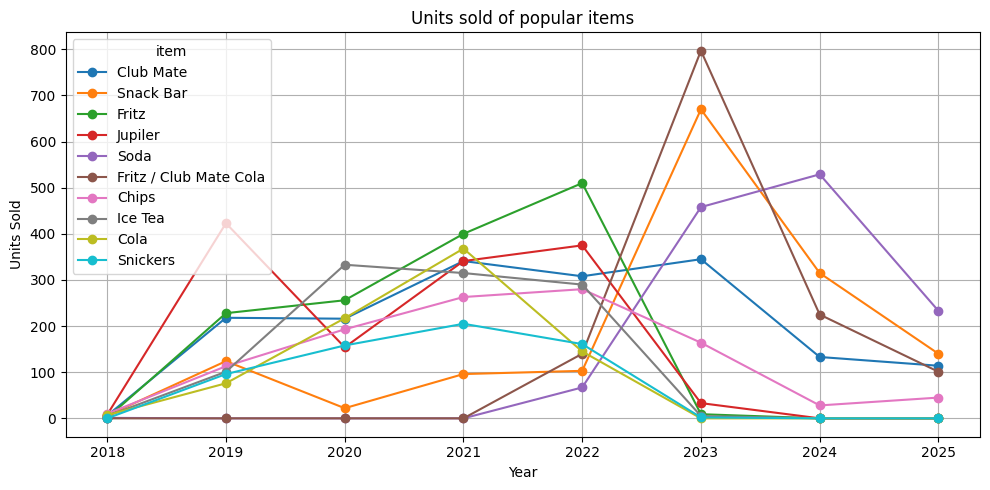

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot lines
plt.figure(figsize=(10, 5))
for item in filtered_yearly_sales.columns:
    plt.plot(filtered_yearly_sales.index, filtered_yearly_sales[item], marker='o', label=item)


plt.title("Units sold of popular items")
plt.ylabel("Units Sold")
plt.xlabel("Year")
plt.legend(title="item")
plt.grid(True)
plt.tight_layout()
plt.show()


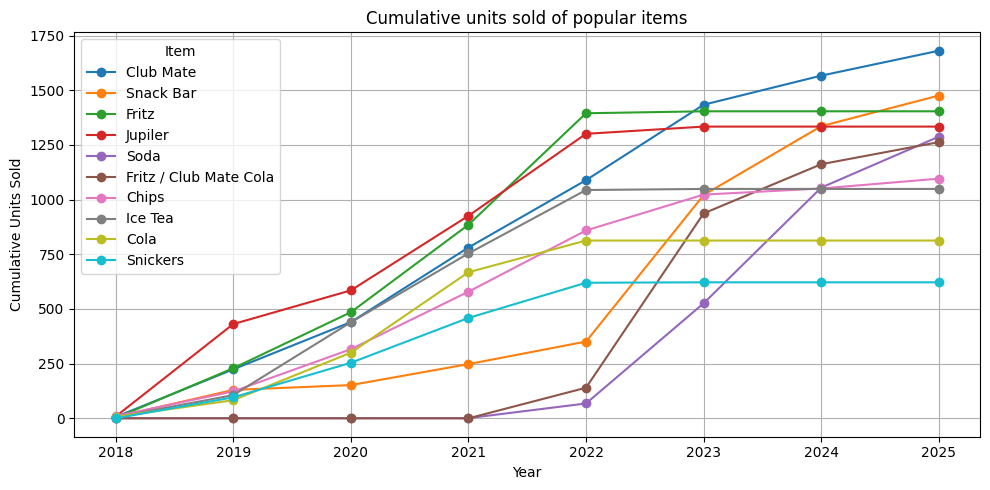

In [59]:
# Calculate cumulative sum over years for each item
cumulative_sales = filtered_yearly_sales.cumsum()

# Plot cumulative units sold per year per item
plt.figure(figsize=(10, 5))
for item in cumulative_sales.columns:
    plt.plot(cumulative_sales.index, cumulative_sales[item], marker='o', label=item)

plt.title("Cumulative units sold of popular items")
plt.ylabel("Cumulative Units Sold")
plt.xlabel("Year")
plt.legend(title="Item")
plt.grid(True)
plt.tight_layout()
plt.show()


# Get revenue of top-n items


In [60]:
# Ensure df_products has price per item indexed
prices = df_products.set_index('name')['price']
prices

name
Soda                      1.5
Cecemel                   0.7
Fritz / Club Mate Cola    2.5
Club Mate                 3.0
Tea                       0.5
                         ... 
Pizza                     2.5
SPRITE                    2.0
Cha-Cha                   0.5
Leffe                     2.0
Orval                     3.0
Name: price, Length: 68, dtype: float64

In [61]:
# Align prices to yearly_sales columns (currencies) This creates a Series indexed by the item name
prices_aligned = prices.reindex(yearly_sales.columns)
prices_aligned

1 Chupa Chups     0.20
Agrumes           1.50
Beer              1.50
Bounty            0.60
Cake              2.50
                  ... 
Twix              0.60
Vitamalz          2.00
Water (bottle)    0.75
Wine              1.50
Wristband         1.00
Name: price, Length: 66, dtype: float64

In [62]:
# Now multiply units sold by prices to get revenue
yearly_revenue = yearly_sales.multiply(prices_aligned, axis='columns')
# Check the first few rows of revenue
yearly_revenue


,1 Chupa Chups,Agrumes,Beer,Bounty,Cake,Cecemel,Cha-Cha,Chimay,Chips,Cider,...,Snickers,Soda,SpacePils,T-Shirt,Tea,Twix,Vitamalz,Water (bottle),Wine,Wristband
year,,,,,,,,,,,,,,,,,,,,,
2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,10.0,0.0,...,0.0,1.5,0.00,0.0,0.0,4.8,2.0,0.75,0.0,0.0
2019,1.2,0.0,0.0,27.0,0.0,0.0,0.0,75.0,113.0,0.0,...,57.6,0.0,0.00,30.0,6.0,37.2,136.0,31.50,0.0,0.0
2020,1.0,0.0,0.0,105.6,0.0,0.0,0.0,0.0,193.0,0.0,...,94.8,0.0,0.00,0.0,0.0,0.0,62.0,5.25,0.0,3.0
2021,5.8,28.5,0.0,97.2,0.0,0.0,0.0,70.0,263.0,188.0,...,123.0,0.0,0.00,75.0,1.0,38.4,68.0,25.50,0.0,0.0
2022,0.2,121.5,100.5,72.0,0.0,12.6,1.0,77.5,280.0,112.0,...,96.6,100.5,0.00,75.0,1.0,71.4,0.0,14.25,43.5,1.0
2023,0.0,0.0,462.0,0.0,0.0,4.9,0.0,0.0,164.0,34.0,...,1.2,687.0,59.85,60.0,1.5,2.4,0.0,25.50,31.5,4.0
2024,0.0,0.0,264.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,...,0.0,793.5,0.00,0.0,0.0,0.0,0.0,38.25,1.5,1.0
2025,0.0,0.0,88.5,0.0,90.0,0.0,0.0,0.0,45.0,0.0,...,0.0,349.5,0.00,45.0,0.0,0.0,0.0,21.75,1.5,0.0


In [63]:
# Sum total units sold per item (column) over all years
total_revenue_per_item = yearly_revenue.sum().sort_values(ascending=False)

# Get the top 10 items by total units sold
top_10_revenue_items = total_revenue_per_item.head(10).index

# Filter yearly_sales to keep only those top 10 columns
filtered_yearly_revenue = yearly_revenue[top_10_revenue_items]
filtered_yearly_revenue

,Club Mate,Fritz,Fritz / Club Mate Cola,Jupiler,Soda,Ice Tea,Snack Bar,Cola,Chips,Fancy Beer
year,,,,,,,,,,
2018,18.0,2.5,0.0,12.0,1.5,7.5,6.0,10.5,10.0,17.5
2019,654.0,570.0,0.0,634.5,0.0,151.5,124.0,114.0,113.0,217.5
2020,648.0,640.0,0.0,231.0,0.0,499.5,22.0,325.5,193.0,67.5
2021,1023.0,1000.0,0.0,511.5,0.0,472.5,96.0,552.0,263.0,122.5
2022,924.0,1275.0,350.0,562.5,100.5,435.0,103.0,217.5,280.0,47.5
2023,1035.0,22.5,1992.5,49.5,687.0,7.5,670.0,0.0,164.0,377.5
2024,399.0,0.0,562.5,0.0,793.5,0.0,315.0,0.0,28.0,140.0
2025,342.0,0.0,252.5,0.0,349.5,0.0,140.0,0.0,45.0,35.0


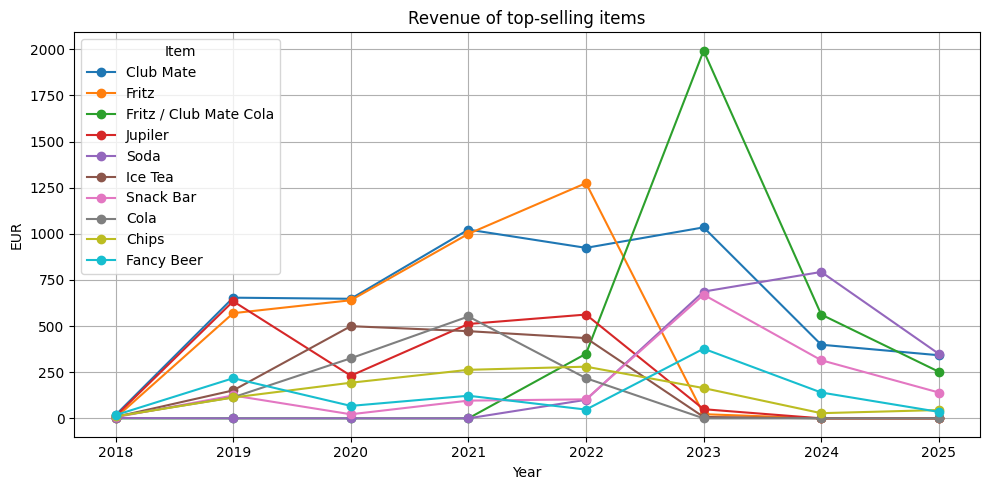

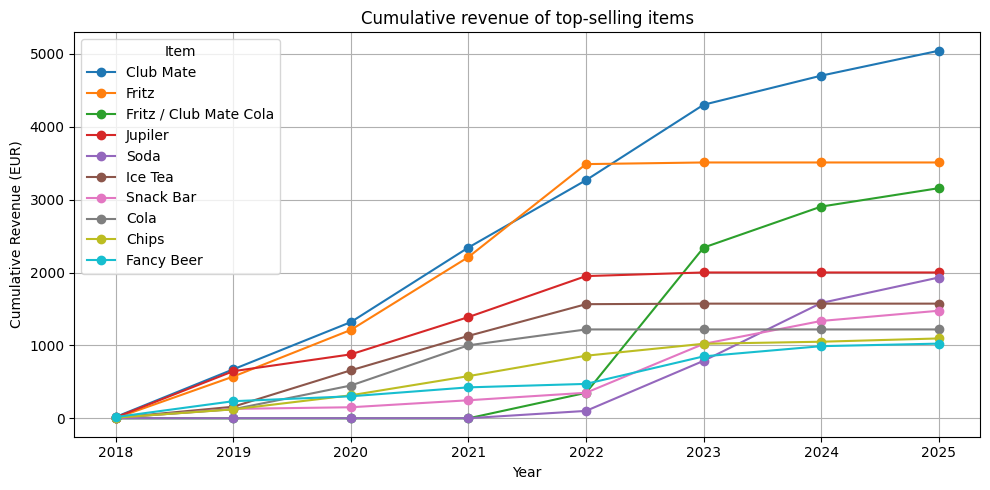

In [64]:
# Plot revenue lines
plt.figure(figsize=(10, 5))
for item in filtered_yearly_revenue.columns:
    plt.plot(filtered_yearly_revenue.index, filtered_yearly_revenue[item], marker='o', label=item)

plt.title("Revenue of top-selling items")
plt.ylabel("EUR")
plt.xlabel("Year")
plt.legend(title="Item")
plt.grid(True)
plt.tight_layout()
plt.show()


# Cumulative revenue over years
cumulative_revenue = filtered_yearly_revenue.cumsum()

plt.figure(figsize=(10, 5))
for item in cumulative_revenue.columns:
    plt.plot(cumulative_revenue.index, cumulative_revenue[item], marker='o', label=item)

plt.title("Cumulative revenue of top-selling items")
plt.ylabel("Cumulative Revenue (EUR)")
plt.xlabel("Year")
plt.legend(title="Item")
plt.grid(True)
plt.tight_layout()
plt.show()



# See debtors

List of debtors, sorted by amount in the red

In [65]:
euro_df = df[df['item'] == 'EUR'].copy()
euro_df['account'] = euro_df['account'].str.extract(r'Liabilities:Bar:Members:(.*)')
euro_df = euro_df.dropna(subset=['account'])

user_balances_eur = -1 * euro_df.groupby('account')['units'].sum()
debtors = user_balances_eur[user_balances_eur < -0.1].sort_values()
debtors



account
Bloemist   -76.29
Err0r       -8.39
Thomas      -7.15
DJ          -6.00
Els         -3.54
Sasja       -3.09
Bertrand    -3.00
Joren       -3.00
Matth       -2.00
Bart        -1.50
Name: units, dtype: float64

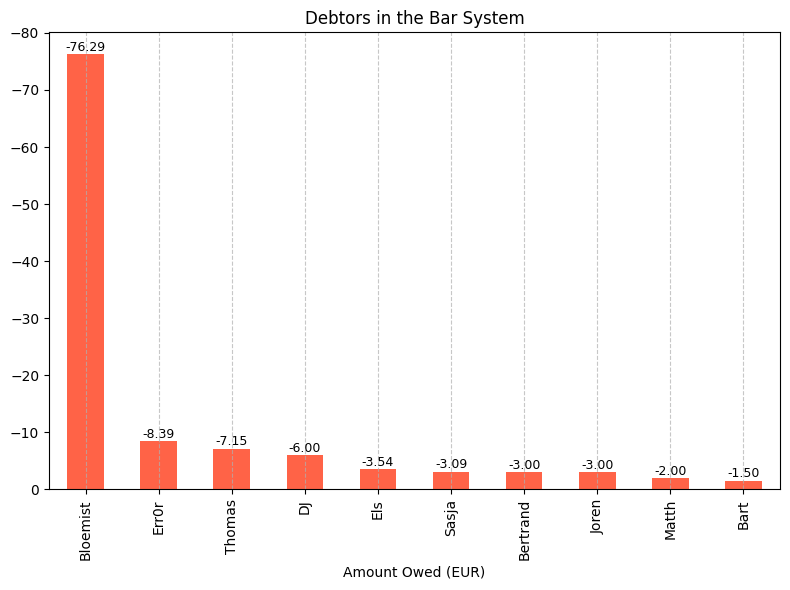

In [66]:
# Ensure numeric type
debtors = debtors.astype(float)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
ax = debtors.plot(kind='bar', color='tomato')

# Invert y-axis
ax.invert_yaxis()

# Annotate each bar with its value
for i, value in enumerate(debtors):
    ax.text(i, value + 0.05 * max(debtors), f'{value:.2f}', 
            ha='center', va='bottom', fontsize=9, color='black')

# Labels and grid
plt.xlabel('Amount Owed (EUR)')
plt.title('Debtors in the Bar System')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Newline report

In [67]:
start_date = '2025-05-23'
end_date = '2025-05-26'

df_newline = df_merged[
    (df_merged['date'] >= start_date) & 
    (df_merged['date'] <= end_date) & 
    (df_merged['type'] == 'purchase') &
    (df_merged['account'] == 'Assets:Inventory:Bar') &
    (df_merged['item'] != 'EUR')
].copy()
df_newline['revenue'] = - df_newline['units'] * df_newline['event_price']
df_newline

,transaction_id,date,narration,account,units,item,type,name,price,event_price,category,visible,payback_account,payback_amount,revenue
99085,137705597172560,2025-05-23,Miker bought 2 items for €5.50,Assets:Inventory:Bar,-1.0,CM,purchase,Club Mate,3.00,4.0,drink,True,NaN,NaN,4.0
99087,137705597172560,2025-05-23,Miker bought 2 items for €5.50,Assets:Inventory:Bar,-1.0,SNACK,purchase,Snack Bar,1.00,1.5,food,True,NaN,NaN,1.5
99091,137705597173344,2025-05-23,Joren bought 1 items for €1.50,Assets:Inventory:Bar,-1.0,SNACK,purchase,Snack Bar,1.00,1.5,food,True,NaN,NaN,1.5
99095,137705597010432,2025-05-23,--CASH-- bought 1 items for €3.50,Assets:Inventory:Bar,-1.0,GERMAN,purchase,Fritz / Club Mate Cola,2.50,3.5,drink,True,NaN,NaN,3.5
99099,137705597011216,2025-05-23,Err0r bought 1 items for €4.00,Assets:Inventory:Bar,-1.0,CM,purchase,Club Mate,3.00,4.0,drink,True,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100155,137705470616720,2025-05-26,Mateo bought 2 items for €2.00,Assets:Inventory:Bar,-2.0,SNACK,purchase,Snack Bar,1.00,1.5,food,True,NaN,NaN,3.0
100159,137705470617504,2025-05-26,Mateo bought 1 items for €0.75,Assets:Inventory:Bar,-1.0,WATER,purchase,Water (bottle),0.75,1.0,drink,True,NaN,NaN,1.0
100163,137705470618288,2025-05-26,Mateo bought 1 items for €1.00,Assets:Inventory:Bar,-1.0,CHIP,purchase,Chips,1.00,1.5,food,True,NaN,NaN,1.5
100167,137705470619072,2025-05-26,Mateo bought 1 items for €1.50,Assets:Inventory:Bar,-1.0,SODA,purchase,Soda,1.50,2.5,drink,True,NaN,NaN,2.5


In [68]:

# Aggregate
sales_per_item = df_newline.groupby("name").agg(
    units_sold=("units", lambda x: -x.sum()),  # negate because purchases were negative
    revenue=("revenue", "sum"),
    price=("event_price", "first")  # assumes price is constant per item
).sort_values(by="revenue", ascending=False)
sales_per_item

,units_sold,revenue,price
name,,,
Club Mate,47.0,188.0,4.0
Fritz / Club Mate Cola,41.0,143.5,3.5
Soda,55.0,137.5,2.5
Croque,43.0,129.0,3.0
Cake,36.0,90.0,2.5
Beer,21.0,52.5,2.5
Cocktail,6.0,36.0,6.0
Fancy Beer,8.0,32.0,4.0
T-Shirt,2.0,30.0,15.0


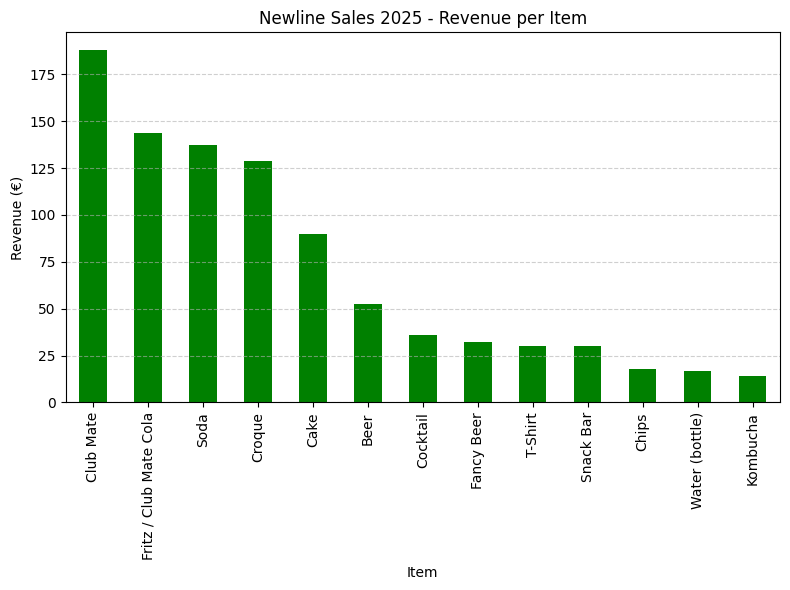

In [69]:
# Plot only the revenue column
plt.figure(figsize=(8, 6))
sales_per_item['revenue'].plot(kind='bar', color='green')
plt.xlabel("Item")
plt.ylabel("Revenue (€)")
plt.title("Newline Sales 2025 - Revenue per Item")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## Total revenue

In [70]:
sales_per_item["revenue"].sum()

np.float64(917.5)